> Baseline model

## BASELINE MODEL - Logistic Regression


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### Loading Data

In [3]:
data = pd.read_csv('../data/processed/data_abnormal_values_treated_scaled.csv') 
data.head()

,Unnamed: 0,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,0,-1.356073,M,ATA,0.446245,0.876016,0,Normal,1.296470,N,-0.862606,Up,0
1,1,-0.408656,F,NAP,1.667669,-1.194233,0,Normal,0.643613,N,0.107330,Flat,1
2,2,-1.671879,M,ATA,-0.164466,0.762057,0,ST,-1.722993,N,-0.862606,Up,0
3,3,-0.513925,F,ASY,0.324103,-0.548467,0,Normal,-1.314958,Y,0.592298,Flat,1
4,4,0.117686,M,NAP,1.056957,-0.909337,0,Normal,-0.743708,N,-0.862606,Up,0


## Seperate X and Y

In [8]:
# seperate X and y dataframes

feature_columns = data.columns[1:-1]

X = data[feature_columns]
y = data['HeartDisease'] 

In [9]:
y.value_counts()

HeartDisease
0    390
1    356
Name: count, dtype: int64


## Feature Engineering
Label Encoding

Use LabelEncoder to assign an integer to each category 

Categorical features: Sex, ChestPainType, FastingBS, RestingECG, ExerciseAngina, ST_Slope


In [10]:
# define categorical columns

cat_cols = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']

# Using OneHotEncoder for categorical features 
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

# ColumnTransformer
preproc = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
    ],
    remainder='passthrough'  # Leave the rest of the columns unchanged
)
preproc

,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,True


In [11]:
# Apply the transformation
X_transformed = preproc.fit_transform(X)

# Reconstruct a DataFrame
ohe_feature_names = preproc.named_transformers_['cat']['encoder'].get_feature_names_out(cat_cols)

# Get the names of the columns that were passed through (the numerical columns)
remainder_features = [col for col in X.columns if col not in cat_cols]

# Combine the lists to create the full list of new column names
new_columns = list(ohe_feature_names) + remainder_features
X_transformed_df = pd.DataFrame(X_transformed, columns=new_columns)

X_transformed_df.head()

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,...,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,-1.356073,0.446245,0.876016,1.296470,-0.862606
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,-0.408656,1.667669,-1.194233,0.643613,0.107330
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,-1.671879,-0.164466,0.762057,-1.722993,-0.862606
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,-0.513925,0.324103,-0.548467,-1.314958,0.592298
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.117686,1.056957,-0.909337,-0.743708,-0.862606


## Pipeline

In [12]:
# 4. Re-define the Model Pipeline
model_pipeline = Pipeline([
    ('Feature Engineering', preproc),
    ('classifier', LogisticRegression(random_state=42)) 
])

model_pipeline

,steps,"[('Feature Engineering', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Train / Test Split

In [13]:
# train/test splitting

X_train, X_test, y_train, y_test = train_test_split(
    X, y, # dataset
    train_size = 0.8, # the size of training set = 80%
    shuffle = True, #to avoid ordering effect
    stratify = y, # maintain the distribution of y classes in both training and test sets
    random_state = 42
)

## Cross Validation

In [14]:

# Define the scoring metrics
scoring = [
    'accuracy',
    'precision',
    'recall',
    'f1',
    'roc_auc'
]

result_dict = cross_validate(model_pipeline, X_train, y_train, cv=5, scoring=scoring)

result = pd.DataFrame(result_dict)
print("\nCross-Validation Results:")
print(result)


Cross-Validation Results:
   fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  \
0  0.088424    0.030480       0.866667        0.872727     0.842105  0.857143   
1  0.017748    0.030901       0.865546        0.822581     0.910714  0.864407   
2  0.017372    0.029039       0.857143        0.844828     0.859649  0.852174   
3  0.016484    0.027474       0.823529        0.800000     0.842105  0.820513   
4  0.017742    0.028491       0.873950        0.850000     0.894737  0.871795   

   test_roc_auc  
0      0.952102  
1      0.907029  
2      0.932654  
3      0.893605  
4      0.942841  


## Model Performance

In [15]:
model_pipeline.fit(X_train, y_train)
#  Evaluate Baseline Model 
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probability for the positive class (1)

# Calculate key metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*60)
print("BASELINE MODEL PERFORMANCE (Logistic Regression)")
print("="*60)
print(f"Accuracy:        {accuracy:.4f}")
print(f"AUC Score:       {auc:.4f}")
print(f"F1 Score:        {f1:.4f}")
print("-" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("-" * 60)




BASELINE MODEL PERFORMANCE (Logistic Regression)
Accuracy:        0.8533
AUC Score:       0.9200
F1 Score:        0.8514
------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        78
           1       0.83      0.88      0.85        72

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150

------------------------------------------------------------


## Confusion Matrix


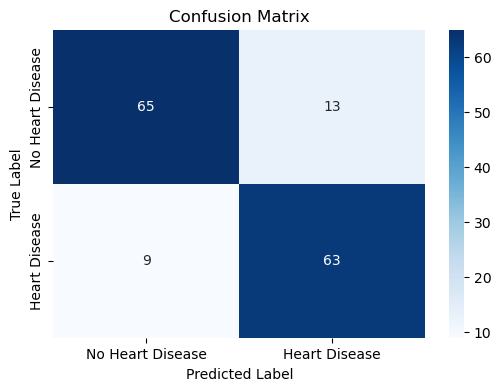

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

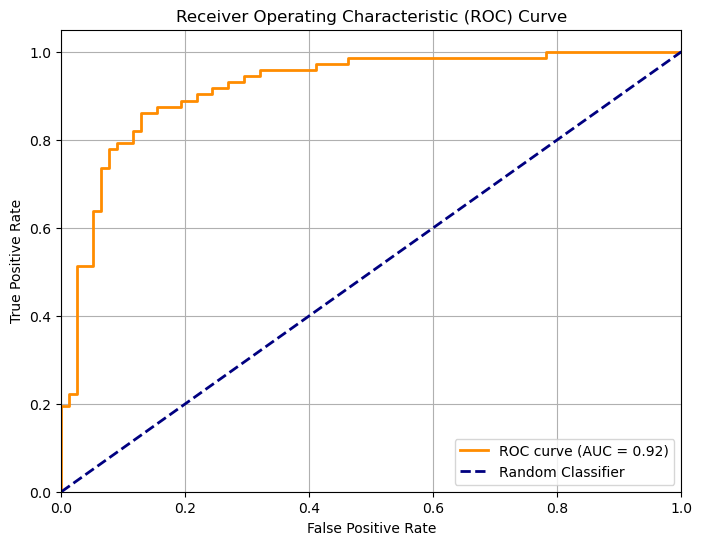

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()